In [29]:
# Imports

import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd


In [30]:
# Audio files are stored in the following directory:
# data/data_final/audios/control
# data/data_final/audios/fess
# data/data_final/audios/septo
# data/data_final/audios/tonsill

# Get all .wav audios from all the directories
path_to_audios = 'data/data_final/audios'
audios = []
for root, dirs, files in os.walk(path_to_audios):
    for name in files:
        if name.endswith('.wav'):
            audios.append(os.path.join(root, name))


In [31]:
# The following code will load the audio files:
def read_audio(path):
    y, sr = librosa.load(path, sr=44100)
    return y, sr

df = pd.DataFrame(columns=['audiopath','audio_raw','label'])
df['audiopath'] = audios
# Get SR and audio in two columns
df[['audio_raw', 'sr']] = df['audiopath'].apply(lambda x: pd.Series(read_audio(x)))
df['label'] = df['audiopath'].apply(lambda x: x.split('/')[3])

In [32]:
# Normalise the audios

def normalize_audio(audio):
    audio = audio / np.max(np.abs(audio))
    return audio

df['audio'] = df['audio_raw'].apply(lambda x: normalize_audio(x))

In [33]:
# Get a new column with the session number extracted from the audio path
df['session'] = df['audiopath'].apply(lambda x: x.split('/')[5])

In [34]:
# Drop all rows which have session aeiou, or concatenateread or tests
df = df[~df['session'].isin(['aeiou', 'concatenateread', 'tests'])]

In [35]:
# Calculate mfccs
def extract_mfcc_with_derivatives(
       audio, sample_rate, frame_length_ms, n_mfcc=10
    ):
        """
        Extracts Mel-frequency cepstral coefficients (MFCCs) with their first and second derivatives from an audio signal.

        Args:
            audio (np.ndarray): The audio signal as a 1D numpy array.
            sample_rate (int): The sample rate of the audio signal.
            frame_length_ms (float): The length of the frames in milliseconds.
            n_mfcc (int): The number of MFCCs to extract.

        Returns:
            np.ndarray: A 2D numpy array of shape (num_frames, num_features) containing the MFCCs and their derivatives.
        """
        frame_length = int(
            sample_rate * frame_length_ms * 1e-3
        )  # Convert ms to samples
        hop_length = int(frame_length / 2)  # 50% overlap
        frames = librosa.util.frame(
            audio, frame_length=frame_length, hop_length=hop_length
        )

        # Apply hanning windows
        frames = frames * np.hanning(frame_length)[:, None]

        # N_fft is the next number in power of 2 of the frame size
        n_fft = 2 ** (int(np.log2(frames.shape[1])) + 1)

        # Compute MFCC for each frame
        mfccs = []
        for frame in frames.T:
            mfcc = librosa.feature.mfcc(
                y=frame, sr=sample_rate, n_mfcc=n_mfcc, n_fft=n_fft
            )
            # Normalize the MFCCs
            mfccs.append(mfcc.T)

        mfccs = np.vstack(mfccs)

        # Normalize the MFCCs
        mfccs = (mfccs - np.mean(mfccs, axis=0)) / np.std(mfccs, axis=0)

        # Compute derivatives
        mfccs_delta = librosa.feature.delta(mfccs)
        mfccs_delta2 = librosa.feature.delta(mfccs, order=2)

        # Concatenate the features
        mfcc_features = np.concatenate((mfccs, mfccs_delta, mfccs_delta2), axis=1)

        return mfcc_features

## COMPUTING MFCCS

Care, this requires time to compute. It took X min and Y secs to compute in a computer with the following specs:

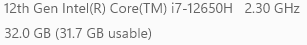

In [39]:
df

,audiopath,audio_raw,label,sr,audio,session
161,data/data_final/audios/fess/a1/3/Cens_ses3_a1_...,"[0.0063171387, 0.0045166016, -0.0010986328, -0...",fess,44100,"[0.048717346, 0.034831725, -0.008472581, -0.05...",3
162,data/data_final/audios/fess/a1/3/Cens_ses3_a1_...,"[0.013153076, 0.010070801, 0.0078125, 0.004791...",fess,44100,"[0.09258861, 0.070891514, 0.054994628, 0.03372...",3
163,data/data_final/audios/fess/a1/3/Cens_ses3_a1_...,"[0.0132751465, 0.030334473, 0.046661377, 0.064...",fess,44100,"[0.07676019, 0.17540145, 0.26980767, 0.3716251...",3
164,data/data_final/audios/fess/a1/3/Cens_ses3_a1_...,"[0.06921387, 0.040405273, 0.0211792, 0.0301818...",fess,44100,"[0.1403118, 0.08191042, 0.042934917, 0.0611853...",3
165,data/data_final/audios/fess/a1/3/Cens_ses3_a1_...,"[0.00894165, 0.006500244, 0.0036010742, -0.000...",fess,44100,"[0.03944534, 0.028675282, 0.015885837, -0.0036...",3
...,...,...,...,...,...,...
4723,data/data_final/audios/septo/brasero/2/Sept_se...,"[-0.0010681152, -0.0010986328, -0.0014038086, ...",septo,44100,"[-0.0031457846, -0.0032356642, -0.00413446, -0...",2
4724,data/data_final/audios/septo/brasero/2/Sept_se...,"[0.0016784668, 0.0020446777, 0.0019226074, 0.0...",septo,44100,"[0.0052671903, 0.0064163953, 0.006033327, 0.00...",2
4725,data/data_final/audios/septo/brasero/2/Sept_se...,"[0.00021362305, 0.0, 6.1035156e-05, 0.00015258...",septo,44100,"[0.0006612507, 0.0, 0.00018892877, 0.000472321...",2
4726,data/data_final/audios/septo/brasero/2/Sept_se...,"[-0.0005187988, -0.000579834, -0.0007019043, -...",septo,44100,"[-0.00097560976, -0.0010903873, -0.0013199426,...",2


In [38]:
# Select only the first session
df_first_session = df[df['session'] == '1']

# Calculate the MFCCs
df_first_session["mfccs"] = df_first_session.apply(
                lambda x: extract_mfcc_with_derivatives(
                    x["audio"],
                    x["sr"],
                    40,
                    13,
                ),
                axis=1,
            )

/home/alexjorguer/miniconda3/lib/python3.11/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/home/alexjorguer/miniconda3/lib/python3.11/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=4096 is too large for input signal of length=1764
  warnings.warn(
/home/alexjorguer/miniconda3/lib/python3.11/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1764
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
df

In [35]:
# Explode the mfccs column
df = df.explode('mfccs')


In [36]:
df

,audiopath,audio_raw,label,sr,audio,mfcc,session,mfccs
161,data/data_final/audios/fess/a1/3/Cens_ses3_a1_...,"[0.0063171387, 0.0045166016, -0.0010986328, -0...",fess,44100,"[0.048717346, 0.034831725, -0.008472581, -0.05...","[[-129.57472, -108.750275, -112.25661, -112.01...",3,"[-129.57472, -108.750275, -112.25661, -112.018..."
161,data/data_final/audios/fess/a1/3/Cens_ses3_a1_...,"[0.0063171387, 0.0045166016, -0.0010986328, -0...",fess,44100,"[0.048717346, 0.034831725, -0.008472581, -0.05...","[[-129.57472, -108.750275, -112.25661, -112.01...",3,"[191.8264, 185.91959, 177.65448, 177.70663, 18..."
161,data/data_final/audios/fess/a1/3/Cens_ses3_a1_...,"[0.0063171387, 0.0045166016, -0.0010986328, -0...",fess,44100,"[0.048717346, 0.034831725, -0.008472581, -0.05...","[[-129.57472, -108.750275, -112.25661, -112.01...",3,"[21.620335, 14.3393, 8.9178915, 10.811967, 8.8..."
161,data/data_final/audios/fess/a1/3/Cens_ses3_a1_...,"[0.0063171387, 0.0045166016, -0.0010986328, -0...",fess,44100,"[0.048717346, 0.034831725, -0.008472581, -0.05...","[[-129.57472, -108.750275, -112.25661, -112.01...",3,"[40.877975, 39.64164, 37.308044, 34.07144, 36...."
161,data/data_final/audios/fess/a1/3/Cens_ses3_a1_...,"[0.0063171387, 0.0045166016, -0.0010986328, -0...",fess,44100,"[0.048717346, 0.034831725, -0.008472581, -0.05...","[[-129.57472, -108.750275, -112.25661, -112.01...",3,"[-24.042002, -33.23491, -35.950577, -34.545624..."
...,...,...,...,...,...,...,...,...
4727,data/data_final/audios/septo/brasero/2/Sept_se...,"[0.0013122559, 0.001373291, 0.0012817383, 0.00...",septo,44100,"[0.0028893966, 0.0030237872, 0.0028222012, 0.0...","[[-222.69905, -184.8898, -169.80875, -151.5345...",2,"[2.4113002, 6.184264, 1.5839164, -4.304047, -7..."
4727,data/data_final/audios/septo/brasero/2/Sept_se...,"[0.0013122559, 0.001373291, 0.0012817383, 0.00...",septo,44100,"[0.0028893966, 0.0030237872, 0.0028222012, 0.0...","[[-222.69905, -184.8898, -169.80875, -151.5345...",2,"[-1.1830914, -0.77726376, 0.48652455, 0.535935..."
4727,data/data_final/audios/septo/brasero/2/Sept_se...,"[0.0013122559, 0.001373291, 0.0012817383, 0.00...",septo,44100,"[0.0028893966, 0.0030237872, 0.0028222012, 0.0...","[[-222.69905, -184.8898, -169.80875, -151.5345...",2,"[-4.468255, -6.9215856, -2.8447056, -1.7200778..."
4727,data/data_final/audios/septo/brasero/2/Sept_se...,"[0.0013122559, 0.001373291, 0.0012817383, 0.00...",septo,44100,"[0.0028893966, 0.0030237872, 0.0028222012, 0.0...","[[-222.69905, -184.8898, -169.80875, -151.5345...",2,"[-2.7512088, -6.1083407, -1.9105326, -2.436734..."


In [41]:
df["mfcc"].iloc[1000].shape

(13, 179)

# KALMAN trajectories

The file .mat containes the information needed to calculate the KALMAN trajectories and the trajectories themselves.

In [24]:
# Read a mat file

import scipy.io

def load_mat_file(mat_file_path):
    # Load the MATLAB file
    mat_data = scipy.io.loadmat(mat_file_path)

    # Extract the 'data' dictionary from the loaded MATLAB file
    data = mat_data['data'][0, 0]

    # Create a Python dictionary from the MATLAB 'data' dictionary
    result_dict = {
        'params': data['params'][0],
        'x': data['x'][0],
        'x_est': data['x_est'][0],
        'x_errVar': data['x_errVar'][0]
    }

    return result_dict

mat_file_path = 'data/data_final/audios/septo/a/1/Sept_ses1_a_0016.mat'
result_dictionary = load_mat_file(mat_file_path)

# Access the data using the keys
params_data = result_dictionary['params']
x_data = result_dictionary['x']
x_est_data = result_dictionary['x_est']
x_errVar_data = result_dictionary['x_errVar']

# x_est:                     Matrix of estimated tracks
#    x_errVar:                  Covariance matrix of estimated tracks
#    x_data:                       Downsampled waveform returned as column vector
#    params:                    Parameters applied, for plotting routines, etc.
